# Refresher

![title](SVM4.png)

![title](SVM1.png)

![title](SVM2.png)

### Create a cost function:
    
J(w) = $\lambda$*$||w||^2$ + $1/n$*$\sum_{i=1}^{n}$max(0, 1-$y_i(w.x_i + b)$)

The first part is to force the magnitude of weights to get minimized - in order to maximize the worst margin

$\frac{1}{||w||^2}$

This indeed means that hard margin SVM tries to minimize ∥w∥2. Due to the formulation of the SVM problem, the margin is 1/∥w∥. As such, minimizing the norm of w is geometrically equivalent to maximizing the margin. Exactly what we want!

The second part is called "Hing Loss" and we use in the SOft margin SVM

since if the training example lies outside the margin ξi will be zero and it will only be nonzero when training example falls into margin region, and since hinge loss is always nonnegative, it happens we can rephrase our problem as

$max(0, 1-y_i(w.x_i + b))$

So if:

- $y_i$*($w^Tx + b$) $\geq$ 1:
        The we dont have the hing loss and only want to minimize the maginitude of w
        
        
- else:

J(w) = $\lambda$*$||w||^2$ + $1/n$*$\sum_{i=1}^{n}$max(0, 1-$y_i(w.x_i + b)$)

### Gradients:

if:
- $y_i$*($w^Tx + b$) $\geq$ 1:

$\frac{dJ}{dw_k}$ = $2\lambda.w_k$
        
- else:

$\frac{dJ}{dw_k}$ = $2\lambda w_k$ -$y_i.x_i$

$\frac{dJ}{db}$ = $-y_i$

### Update rules: GD

$ w = w - \alpha.dw$

$ b = b - \alpha.db$ 

## Hard margin

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors


def visualize_svm(X, y, clf):
    def get_hyperplane_value(x, w, b, offset):
        return (-w[0] * x + b + offset) / w[1]

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.scatter(X[:,0], X[:,1], marker='o',c=y)

    x0_1 = np.amin(X[:,0])
    x0_2 = np.amax(X[:,0])

    x1_1 = get_hyperplane_value(x0_1, clf.w, clf.b, 0)
    x1_2 = get_hyperplane_value(x0_2, clf.w, clf.b, 0)

    x1_1_m = get_hyperplane_value(x0_1, clf.w, clf.b, -1)
    x1_2_m = get_hyperplane_value(x0_2, clf.w, clf.b, -1)

    x1_1_p = get_hyperplane_value(x0_1, clf.w, clf.b, 1)
    x1_2_p = get_hyperplane_value(x0_2, clf.w, clf.b, 1)

    ax.plot([x0_1, x0_2],[x1_1, x1_2], 'y--')
    ax.plot([x0_1, x0_2],[x1_1_m, x1_2_m], 'k')
    ax.plot([x0_1, x0_2],[x1_1_p, x1_2_p], 'k')

    x1_min = np.amin(X[:,1])
    x1_max = np.amax(X[:,1])
    ax.set_ylim([x1_min-3,x1_max+3])

    plt.show()

    
    
    
colors = ['blue','red']
cmap = pltcolors.ListedColormap(colors)


def generateBatchBipolar(n, mu=0.5, sigma=0.2):
    """ Two gaussian clouds on each side of the origin """
    X = np.random.normal(mu, sigma, (n, 2))
    yB = np.random.uniform(0, 1, n) > 0.5
    # y is in {-1, 1}
    y = 2. * yB - 1
    X *= y[:, np.newaxis]
    X -= X.mean(axis=0)
    return X, y

def plotLine(ax, xRange, w, x0, label, color='grey', linestyle='-', alpha=1.):
    """ Plot a (separating) line given the normal vector (weights) and point of intercept """
    if type(x0) == int or type(x0) == float or type(x0) == np.float64:
        x0 = [0, -x0 / w[1]]
    yy = -(w[0] / w[1]) * (xRange - x0[0]) + x0[1]
    ax.plot(xRange, yy, color=color, label=label, linestyle=linestyle)
    
    
def plotSvm(X, y, support=None, w=None, intercept=0., label='Data', separatorLabel='Separator', 
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    """ Plot the SVM separation, and margin """
    if ax is None:
        fig, ax = plt.subplots(1)
    
    im = ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, alpha=0.5, label=label)
    if support is not None:
        ax.scatter(support[:,0], support[:,1], label='Support', s=80, facecolors='none', 
                   edgecolors='y', color='y')
        print("Number of support vectors = %d" % (len(support)))
    if w is not None:
        xx = np.array(bound[0])
        plotLine(ax, xx, w, intercept, separatorLabel)
        # Plot margin
        if support is not None:
            signedDist = np.matmul(support, w)
            margin = np.max(signedDist) - np.min(signedDist) * np.sqrt(np.dot(w, w))
            supportMaxNeg = support[np.argmin(signedDist)]
            plotLine(ax, xx, w, supportMaxNeg, 'Margin -', linestyle='-.', alpha=0.8)
            supportMaxPos = support[np.argmax(signedDist)]
            plotLine(ax, xx, w, supportMaxPos, 'Margin +', linestyle='--', alpha=0.8)
            ax.set_title('Margin = %.3f' % (margin))
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])
    cb = plt.colorbar(im, ax=ax)
    loc = np.arange(-1,1,1)
    cb.set_ticks(loc)
    cb.set_ticklabels(['-1','1'])

###  Solving using Sequential least squares programing (SLSQP)

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize

In [12]:
import numpy as np
import matplotlib.pyplot as plt
#from svm_utils import datasets
from sklearn import datasets


In [13]:
class HardMarginSVM:
  def __init__(self, learning_rate = 0.001, lambda_param = 0.001, n_iters = 1000):
      self.learning_rate = learning_rate
      self.lambda_param = lambda_param
      self.n_iters = n_iters

  def fit(self, X, y):
      n_samples, n_features = X.shape
      y_ = np.where(y <= 0, -1, 1)

      self.w = np.zeros(n_features)
      self.b = 0

      for _ in range(self.n_iters):
        for idx, x_i in enumerate(X):
          condition = y_[idx] * (np.dot(x_i, self.w) + self.b) >= 1

          if condition:
            self.w -= self.learning_rate * (2 * self.lambda_param * self.w)

          else:
            self.w -= self.learning_rate * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))

            self.b -= self.learning_rate * (-y_[idx])



  def predict(self, X):
    pred_ = np.dot(X, self.w) + self.b
    return np.sign(pred_)

  


In [14]:
X, y = datasets.make_blobs(n_samples=1000, n_features=2, centers=2, cluster_std=1.005, random_state=40)

clf = HardMarginSVM()
clf.fit(X,y)

print(clf.w, clf.b)



[0.90062831 0.30360742] 0.17800000000000013


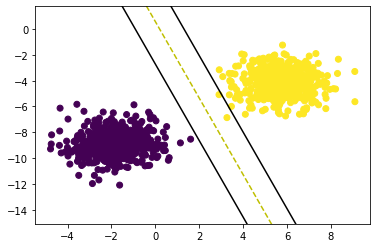

In [15]:
visualize_svm(X, y, clf)

In [16]:
from scipy import optimize
from sklearn import svm
import seaborn as sns

from scipy.optimize import slsqp, Bounds

In [17]:
n = 1000
nFeatures = 2
X, y = generateBatchBipolar(n, sigma=0.4)

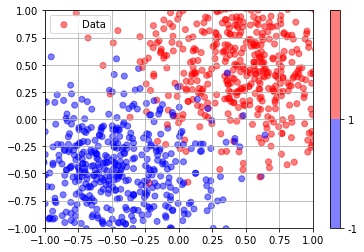

In [18]:
plotSvm(X, y)

In [24]:
from operator import le
class SoftMarginSVM:
  def __init__(self, C):
      self.C= C
      # self.
      # self.
      # self.
      # self.

  def fit(self, X, y):
    N = len(y)

    Xy = X*y[: ,np.newaxis]
    GramXy = np.matmul(Xy, Xy.T)

    def ld0(G, alpha):
      return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))

    def derivativeLd0(G, alpha):
      return np.ones_like(alpha) - alpha.dot(G)

    alpha = np.ones(N)
    bounds_alpha = Bounds(np.zeros(N), np.full(N, self.C))

    # A = np.vstack((-np.eye(N), np.eye(N)))
    constraints = ({
                    'type': 'eq',
                    'fun': lambda a: np.dot(a, y),
                    'jac': lambda a: y
                    })
    
    optRes = optimize.minimize(fun = lambda a: -ld0(GramXy, a), 
                               x0 = alpha,
                               jac = lambda a: derivativeLd0(GramXy,a),
                               constraints = constraints,
                               bounds = bounds_alpha, 
                               method = 'SLSQP'
                               )
    
    self.alpha = optRes.x
    self.w = np.sum((self.alpha[:, np.newaxis]* Xy), axis = 0)
    
    epsilon = 1e-4
    
    self.supportVectors = X[self.alpha > epsilon]
    self.supportLabels = y[self.alpha > epsilon]

    # Bishop book 7.69 equation
    b = []
    for i in range(len(self.supportVectors)):
      b_i = self.supportLabels[i] - np.matmul(self.supportVectors[i].T, self.w)
      b.append(b_i)

    self.intercept = sum(b) / len(b)





In [25]:
model = SoftMarginSVM(C=5)
model.fit(X, y)

Number of support vectors = 1000


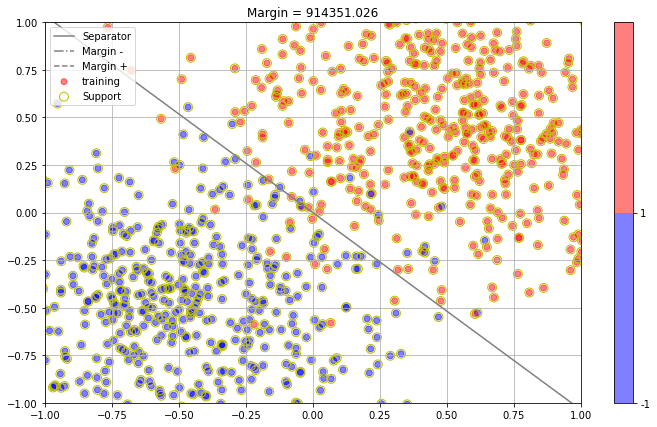

In [26]:
fig, ax = plt.subplots(1, figsize = (12, 7))
plotSvm(X, 
        y, 
        model.supportVectors, 
        model.w, 
        model.intercept,
        label='training', 
        ax=ax)

In [27]:
model1 = svm.SVC(kernel='linear', C=5)
model1.fit(X, y)

SVC(C=5, kernel='linear')

In [ ]:
plotSvm(X, 
        y, 
        model1.supportVectors, 
        model1.w, 
        model1.intercept,
        label='training', 
        ax=ax)